In [1]:
import pandas as pd
import geopandas as gpd


/home/ryzzr/miniconda3/envs/PDP/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
df_f = pd.read_csv('data/dane_szczepien.csv', sep=';',
                   encoding='utf-8')[['powiat_nazwa', 'wojewodztwo_nazwa']].groupby(['powiat_nazwa', 'wojewodztwo_nazwa']).sum().reset_index()


In [3]:
# df = pd.read_csv('daneaktualne_szczepienia/20220123075316_rap_rcb_pow_szczepienia.csv',
#                  sep=';', encoding='windows-1250')
df_vacc = pd.read_csv('data/dane_szczepien.csv', sep=';',
                      encoding='utf-8').groupby('powiat_nazwa').sum().reset_index()
df_vacc = pd.merge(df_vacc, df_f, on='powiat_nazwa')
df_vacc_filtered = df_vacc[['powiat_nazwa', 'wojewodztwo_nazwa', 'powiat_teryt', 'liczba_ludnosci',
                            'w1_zaszczepieni_pacjenci', 'w3_zaszczepieni_pelna_dawka']]
df_distr = gpd.read_file("data/powiaty-max.geojson")

In [4]:
df_distr['powiat_nazwa'] = df_distr['nazwa'].apply(lambda x: x.split(' ')[-1])
df_vacc_filtered['czesc_wyszczepienia'] = df_vacc_filtered['w3_zaszczepieni_pelna_dawka'] / df_vacc_filtered['liczba_ludnosci']


/tmp/ipykernel_46057/846998864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vacc_filtered['czesc_wyszczepienia'] = df_vacc_filtered['w3_zaszczepieni_pelna_dawka'] / df_vacc_filtered['liczba_ludnosci']


In [5]:
print(df_distr.shape)
print(df_vacc_filtered.shape)


(380, 4)
(380, 7)


In [6]:
full_df = pd.merge(df_distr, df_vacc_filtered, on='powiat_nazwa')


In [7]:
full_df.head()

,id,nazwa,geometry,powiat_nazwa,wojewodztwo_nazwa,powiat_teryt,liczba_ludnosci,w1_zaszczepieni_pacjenci,w3_zaszczepieni_pelna_dawka,czesc_wyszczepienia
0,1,powiat ropczycko-sędziszowski,"MULTIPOLYGON (((21.69430 50.17850, 21.69440 50...",ropczycko-sędziszowski,podkarpackie,9075,74573,26486,25616,0.343502
1,2,powiat łosicki,"MULTIPOLYGON (((22.72380 52.28040, 22.72380 52...",łosicki,mazowieckie,8460,30556,13894,13432,0.439586
2,3,powiat piaseczyński,"MULTIPOLYGON (((21.11010 52.11320, 21.10880 52...",piaseczyński,mazowieckie,8508,190606,135754,129879,0.681400
3,4,powiat radomski,"MULTIPOLYGON (((20.98910 51.48950, 20.98920 51...",radomski,mazowieckie,18525,152190,71520,69009,0.453440
4,5,powiat sierpecki,"MULTIPOLYGON (((19.50880 52.86780, 19.50870 52...",sierpecki,mazowieckie,9989,51534,27373,26393,0.512147


# Folium

In [8]:
import folium

In [10]:
geo_powiaty = "data/powiaty-max.geojson"
with open(geo_powiaty, encoding="utf8") as file_powiaty:
    text_powiaty = file_powiaty.read()


In [ ]:
m = folium.Map(location=[52, 19.23], zoom_start=7, tiles='stamentoner')
folium.Choropleth(geo_data=text_powiaty,
    data=full_df,
    columns=['nazwa', 'czesc_wyszczepienia'],
    legend_name='Część wyszczepienia',
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.5,
    key_on='feature.properties.nazwa',
).add_to(m)

m


# Dane z AMC


In [8]:
df_amc = pd.read_json(
    "data/location_data_all_v2.json")[['powiat_str', 'latitude', 'longitude', 'y3classes_sum', 'y3classes_str_general']]
df_amc['nazwa'] = df_amc['powiat_str']
df_amc.drop('powiat_str', axis=1)

df_amc = df_amc.groupby('nazwa').sum().reset_index()


In [9]:
full_df_amc = pd.merge(df_amc, full_df, on='nazwa')

In [10]:
full_df_amc = gpd.GeoDataFrame(full_df_amc)


In [11]:
full_df_amc.head(3)


,nazwa,latitude,longitude,y3classes_sum,id,geometry,powiat_nazwa,wojewodztwo_nazwa,powiat_teryt,liczba_ludnosci,w1_zaszczepieni_pacjenci,w3_zaszczepieni_pelna_dawka,czesc_wyszczepienia
0,powiat Białystok,9297.295323,4051.021697,400,352,"MULTIPOLYGON (((23.21310 53.06660, 23.21290 53...",Białystok,podlaskie,2061,296958,167222,161165,0.542720
1,powiat Bielsko-Biała,4185.075097,1599.742464,981,194,"MULTIPOLYGON (((18.98640 49.73670, 18.98560 49...",Bielsko-Biała,śląskie,2461,169756,105655,102106,0.601487
2,powiat Bydgoszcz,9296.438742,3150.394744,752,369,"MULTIPOLYGON (((18.03980 53.05010, 18.03980 53...",Bydgoszcz,kujawsko-pomorskie,461,344091,225192,217225,0.631301


# ML

In [12]:
variable_names = [
    'y3classes_sum',
    'powiat_teryt',
    'liczba_ludnosci',
]


In [13]:
from pysal.model import spreg


In [14]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variable name
    name_x=variable_names
)


In [15]:
print(m1.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :           4
S.D. dependent var  :      0.0658                Degrees of Freedom    :         360
R-squared           :      0.1497
Adjusted R-squared  :      0.1426
Sum squared residual:       1.338                F-statistic           :     21.1251
Sigma-square        :       0.004                Prob(F-statistic)     :   1.256e-12
S.E. of regression  :       0.061                Log likelihood        :     503.794
Sigma-square ML     :       0.004                Akaike info criterion :    -999.588
S.E of regression ML:      0.0606                Schwarz criterion     :    -983.999

----------------------------------------------------------------------

In [16]:
from pysal.lib import weights
knn = weights.KNN.from_dataframe(full_df_amc, k=1)


/home/ryzzr/miniconda3/envs/PDP/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 106 disconnected components.
  warnings.warn(message)


/home/ryzzr/miniconda3/envs/PDP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

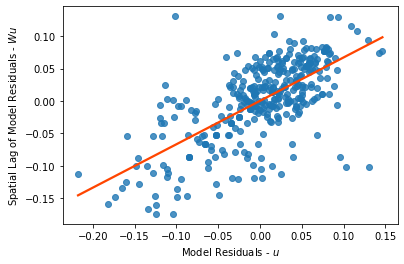

In [17]:
import seaborn

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$')


/home/ryzzr/miniconda3/envs/PDP/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


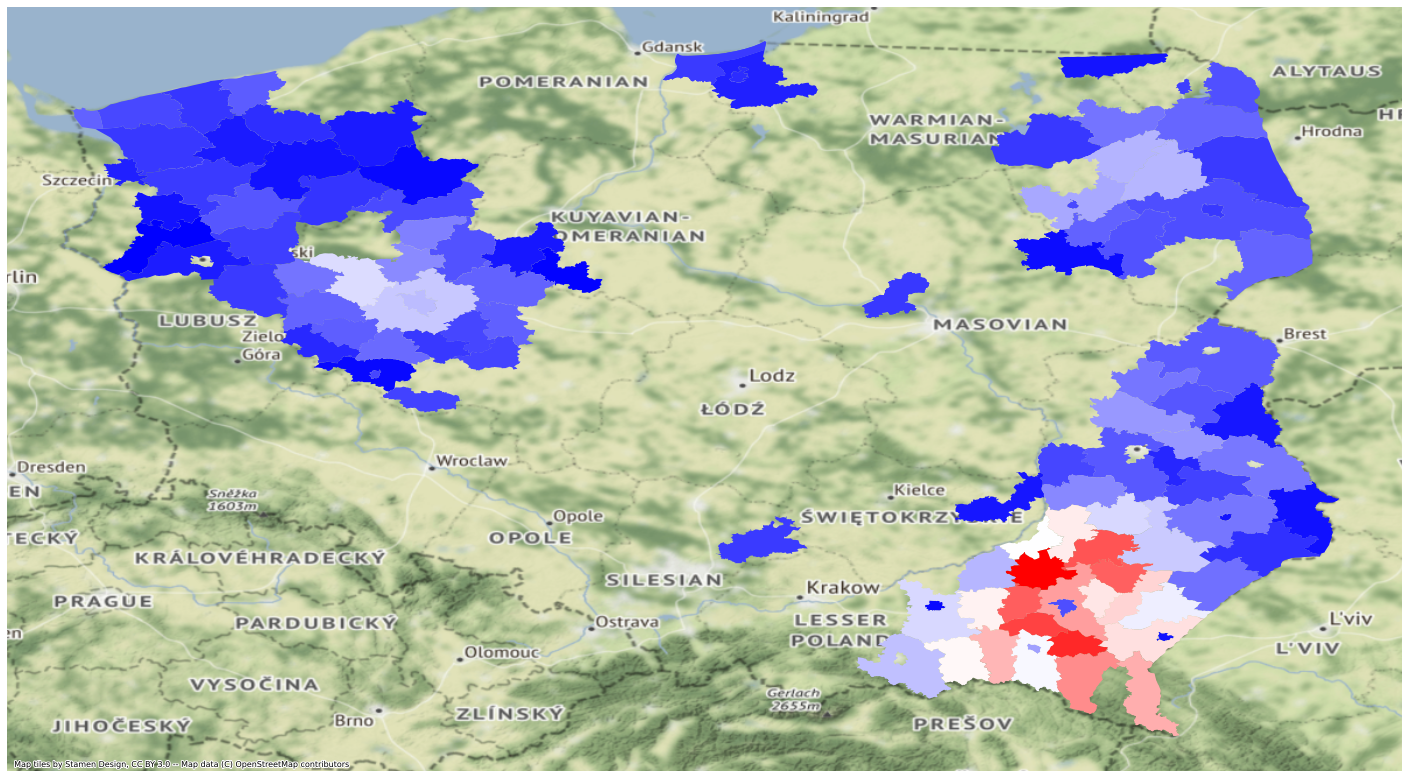

In [18]:
from pysal.explore import esda
import contextily
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(25, 25))
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardise weights
knn.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns

temp = full_df_amc.assign(
    error_clusters=error_clusters,
    local_I=outliers.Is
    # Retain error clusters only
).query(
    "error_clusters"
    # Sort by I value to largest plot on top
).sort_values(
    'local_I'
    # Plot I values
)

temp.plot(
    'local_I', cmap='bwr', marker='.', ax=ax
)
# Add basemap
contextily.add_basemap(ax, crs=temp.crs)
# Remove axes
ax.set_axis_off()

THERE IS ROOM FOR SPATIAL IMPROVEMENT!!!!

# Spatial ML

In [19]:
import statsmodels.formula.api as sm
from shapely.geometry import Point


In [20]:
# Czy jest w pobliżu najlepiej komentujących?
rk = weights.Rook.from_dataframe(full_df_amc)

full_df_amc['pos_neg_per_person'] = full_df_amc['y3classes_sum'] / full_df_amc['liczba_ludnosci']
full_df_amc['neighbouring_powiaty'] = [[full_df_amc.iloc[x]['powiat_nazwa'] for x in n_powiaty]
                                       for n_powiaty in list(rk.neighbors.values())]

most_pos = list(full_df_amc.sort_values('pos_neg_per_person', ascending=False).head(25)['powiat_nazwa'])
most_neg = list(full_df_amc.sort_values('pos_neg_per_person', ascending=True).head(25)['powiat_nazwa'])

def powiatowy(x):
    total = 0
    for y in x:
        if y in most_pos:
            total += 1
        elif y in most_neg:
            total -= 1
    return 1 if total > 0 else -1 if total < 0 else 0 

full_df_amc['neighborhood_pozytywny'] = full_df_amc['neighbouring_powiaty'].apply(powiatowy)


<AxesSubplot:>

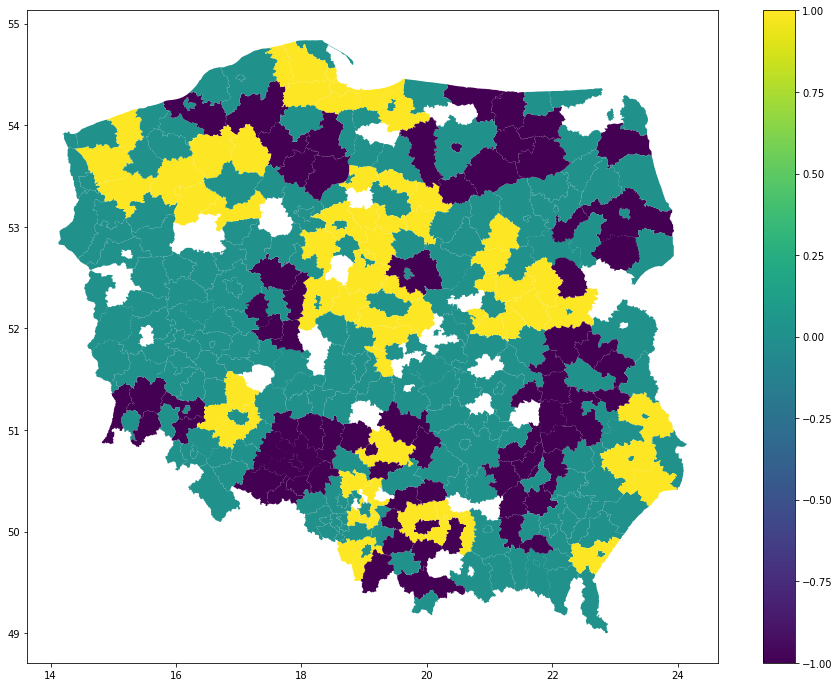

In [24]:
full_df_amc.plot(column='neighborhood_pozytywny', categorical=False, legend=True, figsize=(16,12))


In [176]:
# variable_names.append('neighborhood_pozytywny')
variable_names.append('pos_neg_per_person')

### Po dodaniu województw jako zależności geograficznych.

In [35]:
# PySAL spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Variable specifying neighborhood membership
    full_df_amc['wojewodztwo_nazwa'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    cols2regi=[True]*len(variable_names),
    regime_err_sep=True,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=variable_names
)


In [36]:
print(m4.summary)


REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME dolnośląskie
--------------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :dolnośląskie_czesc_wyszczepienia                Number of Observations:          29
Mean dependent var  :      0.5440                Number of Variables   :           4
S.D. dependent var  :      0.0430                Degrees of Freedom    :          25
R-squared           :      0.6060
Adjusted R-squared  :      0.5587
Sum squared residual:       0.020                F-statistic           :     12.8174
Sigma-square        :       0.001                Prob(F-statistic)     :   2.875e-05
S.E. of regression  :       0.029                Log likelihood        :      64.105
Sigma-square ML     :       0.001                Akaike info criterion :    -120.209
S.E of regression ML:      0.0265                Schwarz criterion     :    

Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

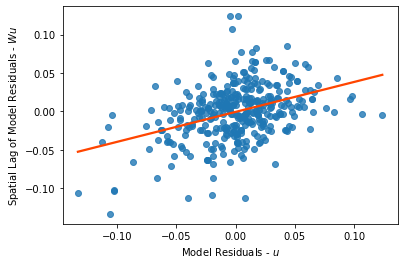

In [40]:
knn = weights.KNN.from_dataframe(full_df_amc, k=1)
lag_residual = weights.spatial_lag.lag_spatial(knn, m4.u)
ax = seaborn.regplot(
    m4.u.flatten(),
    lag_residual.flatten(),
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$')


### Po sprawdzeniu "najbardziej pozytywnych i negatywnych" sąsiadów jako zależności geo

In [41]:
# PySAL spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    full_df_amc[variable_names].values,
    # Variable specifying neighborhood membership
    full_df_amc['neighborhood_pozytywny'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=variable_names
)


In [42]:
print(m5.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :          12
S.D. dependent var  :      0.0658                Degrees of Freedom    :         352
R-squared           :      0.2246
Adjusted R-squared  :      0.2004
Sum squared residual:       1.220                F-statistic           :      9.2692
Sigma-square        :       0.003                Prob(F-statistic)     :   1.238e-14
S.E. of regression  :       0.059                Log likelihood        :     520.579
Sigma-square ML     :       0.003                Akaike info criterion :   -1017.158
S.E of regression ML:      0.0579                Schwarz criterion     :    -970.392

--------------------------------------------------

### Dodanie spacial lag'a

In [43]:
wx = full_df_amc[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
    # Rename the spatial lag, adding w_ to the original name
).rename(columns=lambda c: 'w_'+c
    # Remove the lag of the binary variable for apartments
         )

slx_exog = full_df_amc[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)


In [45]:
print(m6.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :           7
S.D. dependent var  :      0.0658                Degrees of Freedom    :         357
R-squared           :      0.1940
Adjusted R-squared  :      0.1804
Sum squared residual:       1.268                F-statistic           :     14.3207
Sigma-square        :       0.004                Prob(F-statistic)     :   1.221e-14
S.E. of regression  :       0.060                Log likelihood        :     513.532
Sigma-square ML     :       0.003                Akaike info criterion :   -1013.065
S.E of regression ML:      0.0590                Schwarz criterion     :    -985.784

----------------------------------------------------------------------

# All together!

In [46]:
full_df_amc = pd.merge(df_amc, full_df, on='nazwa')
full_df_amc = gpd.GeoDataFrame(full_df_amc)

variable_names = [
    'y3classes_sum',
    'powiat_teryt',
    'liczba_ludnosci',
]

rk = weights.Rook.from_dataframe(full_df_amc)

full_df_amc['pos_neg_per_person'] = full_df_amc['y3classes_sum'] / full_df_amc['liczba_ludnosci']
full_df_amc['neighbouring_powiaty'] = [[full_df_amc.iloc[x]['powiat_nazwa'] for x in n_powiaty]
                                       for n_powiaty in list(rk.neighbors.values())]

most_pos = list(full_df_amc.sort_values('pos_neg_per_person', ascending=False).head(25)['powiat_nazwa'])
most_neg = list(full_df_amc.sort_values('pos_neg_per_person', ascending=True).head(25)['powiat_nazwa'])


def powiatowy(x):
    total = 0
    for y in x:
        if y in most_pos:
            total += 1
        elif y in most_neg:
            total -= 1
    return 1 if total > 0 else -1 if total < 0 else 0


full_df_amc['neighborhood_pozytywny'] = full_df_amc['neighbouring_powiaty'].apply(powiatowy)

variable_names.append('neighborhood_pozytywny') # Adding this info as a var
variable_names.append('pos_neg_per_person')

knn = weights.KNN.from_dataframe(full_df_amc, k=20)
wx = full_df_amc[variable_names].apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
    # Rename the spatial lag, adding w_ to the original name
).rename(columns=lambda c: 'w_'+c
         # Remove the lag of the binary variable for apartments
         )

slx_exog = full_df_amc[variable_names].join(wx)


In [58]:
slx_exog.iloc[0]


y3classes_sum               4.000000e+02
powiat_teryt                2.061000e+03
liczba_ludnosci             2.969580e+05
neighborhood_pozytywny      0.000000e+00
pos_neg_per_person          1.346992e-03
w_y3classes_sum             4.680000e+02
w_powiat_teryt              3.805580e+05
w_liczba_ludnosci           1.904465e+06
w_neighborhood_pozytywny   -6.000000e+00
w_pos_neg_per_person        6.313307e-03
Name: 0, dtype: float64

In [69]:
m7 = spreg.OLS_Regimes(
    # Dependent variable
    full_df_amc[['czesc_wyszczepienia']].values,
    # Independent variables
    slx_exog.values,
    # Variable specifying neighborhood membership
    full_df_amc['wojewodztwo_nazwa'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',

    cols2regi=[False]*len(variable_names) + [True]*len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='czesc_wyszczepienia',
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)


In [70]:
print(m7.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :czesc_wyszczepienia                Number of Observations:         364
Mean dependent var  :      0.5293                Number of Variables   :         101
S.D. dependent var  :      0.0658                Degrees of Freedom    :         263
R-squared           :      0.7464
Adjusted R-squared  :      0.6500
Sum squared residual:       0.399                F-statistic           :      7.7426
Sigma-square        :       0.002                Prob(F-statistic)     :   1.348e-40
S.E. of regression  :       0.039                Log likelihood        :     724.019
Sigma-square ML     :       0.001                Akaike info criterion :   -1246.037
S.E of regression ML:      0.0331                Schwarz criterion     :    -852.425

--------------------------------------------------

# TEST AREA